# ML-Based Short-Term Futures Price Prediction Using Order Book Data

This notebook implements a machine learning pipeline to predict short-term futures prices using real-time order book data fetched via WebSocket connections.

In [1]:
# Set LD_LIBRARY_PATH for GPU support (run this cell first if GPU not detected)
import os
os.environ['LD_LIBRARY_PATH'] = os.environ.get('CONDA_PREFIX', '') + '/lib:' + os.environ.get('LD_LIBRARY_PATH', '')

## 1. Import Required Libraries

Import libraries for data fetching, processing, and modeling.

In [2]:
import websocket
import json
import pandas as pd
import numpy as np
from datetime import datetime
import time
import os
import threading
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv2D, Flatten
import matplotlib.pyplot as plt
import subprocess
import os

2026-01-19 00:36:39.916776: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### GPU Availability Check

In [3]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2.5 Start Background Data Fetcher

Run the separate data fetcher script to collect real-time order book data in the background.

In [ ]:


fetcher_script = 'data_fetcher.py'
if os.path.exists(fetcher_script):
    print("Starting background data fetcher...")
    process = subprocess.Popen(['python', fetcher_script], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    print(f"Data fetcher started with PID: {process.pid}")
    print("It will collect data to 'live_order_book_data.csv'")
else:
    print(f"Data fetcher script '{fetcher_script}' not found. Please ensure it's in the same directory.")

# Kill If you wanna terminate live data fetching

In [ ]:
!pkill -f data_fetcher.py

In [4]:
# Load data from background fetcher
DATA_FILE = 'live_order_book_data.csv'

if os.path.exists(DATA_FILE):
    df = pd.read_csv(DATA_FILE)
    print(f"Loaded {len(df)} records from {DATA_FILE}")
    # Ensure timestamp is datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Parse string columns back to lists
    import ast
    df['bid_prices'] = df['bid_prices'].apply(ast.literal_eval)
    df['bid_quantities'] = df['bid_quantities'].apply(ast.literal_eval)
    df['ask_prices'] = df['ask_prices'].apply(ast.literal_eval)
    df['ask_quantities'] = df['ask_quantities'].apply(ast.literal_eval)
    
    # Data Validation
    print("Performing data validation...")
    # Check for duplicates
    duplicates = df.duplicated(subset=['timestamp']).sum()
    print(f"Duplicate timestamps: {duplicates}")
    if duplicates > 0:
        df = df.drop_duplicates(subset=['timestamp'])
    
    # Check for missing or invalid lists
    def validate_lists(row):
        try:
            if not isinstance(row['bid_prices'], list) or not isinstance(row['ask_prices'], list):
                return False
            if len(row['bid_prices']) == 0 or len(row['ask_prices']) == 0:
                return False
            # Check monotonicity (bids descending, asks ascending)
            if row['bid_prices'] != sorted(row['bid_prices'], reverse=True):
                return False
            if row['ask_prices'] != sorted(row['ask_prices']):
                return False
            return True
        except:
            return False
    
    valid_mask = df.apply(validate_lists, axis=1)
    invalid_count = (~valid_mask).sum()
    print(f"Invalid order book entries: {invalid_count}")
    df = df[valid_mask]
    
    # Outlier detection for mid_price
    df['temp_mid_price'] = df.apply(lambda row: (row['bid_prices'][0] + row['ask_prices'][0]) / 2, axis=1)
    q1 = df['temp_mid_price'].quantile(0.25)
    q3 = df['temp_mid_price'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = ((df['temp_mid_price'] < lower_bound) | (df['temp_mid_price'] > upper_bound)).sum()
    print(f"Price outliers detected: {outliers}")
    df = df[(df['temp_mid_price'] >= lower_bound) & (df['temp_mid_price'] <= upper_bound)]
    df = df.drop(columns=['temp_mid_price'])
    
    print(f"Data after validation: {len(df)} records")
    
else:
    print(f"Data file {DATA_FILE} not found. Please run the background data fetcher first.")
    df = pd.DataFrame()  # Empty dataframe

Loaded 243776 records from live_order_book_data.csv


SyntaxError: invalid syntax (<unknown>, line 1)

## 4. Feature Engineering from Order Book Data

Compute features like bid-ask imbalance, mid-price, spread, and volatility metrics.

In [4]:
# Optimized Feature Engineering for Large Datasets (e.g., 1M rows)
import numpy as np

# Constants
K = 10  # Top levels to consider
MAX_LEVELS = 20  # For order book image

# Vectorized features where possible
df['mid_price'] = df.apply(lambda row: (row['bid_prices'][0] + row['ask_prices'][0]) / 2, axis=1)  # Keep simple for now, or vectorize if possible
df['spread'] = df.apply(lambda row: row['ask_prices'][0] - row['bid_prices'][0], axis=1)

# For list-based features, use efficient slicing and summation
def safe_slice_sum(lst, k):
    return sum(lst[:k]) if len(lst) >= k else sum(lst)

def safe_weighted_avg(prices, quantities, k):
    if len(prices) < k or len(quantities) < k:
        k = min(len(prices), len(quantities))
    if k == 0:
        return 0
    total_vol = sum(quantities[:k])
    if total_vol == 0:
        return prices[0] if prices else 0
    return sum(p * q for p, q in zip(prices[:k], quantities[:k])) / total_vol

# Imbalance
df['bid_sum_k'] = df['bid_quantities'].apply(lambda x: safe_slice_sum(x, K))
df['ask_sum_k'] = df['ask_quantities'].apply(lambda x: safe_slice_sum(x, K))
df['imbalance'] = (df['bid_sum_k'] - df['ask_sum_k']) / (df['bid_sum_k'] + df['ask_sum_k']).replace(0, np.nan)
df['imbalance'] = df['imbalance'].fillna(0)

# Weighted mid-price
df['bid_weighted'] = df.apply(lambda row: safe_weighted_avg(row['bid_prices'], row['bid_quantities'], K), axis=1)
df['ask_weighted'] = df.apply(lambda row: safe_weighted_avg(row['ask_prices'], row['ask_quantities'], K), axis=1)
df['weighted_mid_price'] = (df['bid_weighted'] + df['ask_weighted']) / 2

# Cumulative volumes
df['bid_cum_volume'] = df['bid_quantities'].apply(lambda x: safe_slice_sum(x, K))
df['ask_cum_volume'] = df['ask_quantities'].apply(lambda x: safe_slice_sum(x, K))

# Slopes (using vectorized linregress approximation or precompute)
def slope_linregress(prices, k):
    if len(prices) < k:
        return 0
    x = np.arange(k)
    y = np.array(prices[:k])
    if len(np.unique(x)) < 2:
        return 0
    slope = np.polyfit(x, y, 1)[0]
    return slope

df['bid_slope'] = df['bid_prices'].apply(lambda x: slope_linregress(x, K))
df['ask_slope'] = df['ask_prices'].apply(lambda x: slope_linregress(x, K))

# Depth and liquidity ratio
df['depth'] = df['bid_sum_k'] + df['ask_sum_k']
df['liquidity_ratio'] = df['bid_sum_k'] / df['ask_sum_k'].replace(0, np.nan)
df['liquidity_ratio'] = df['liquidity_ratio'].fillna(0)

# Rolling volatility (already vectorized)
df['mid_price_volatility'] = df['mid_price'].rolling(window=10).std()

# Price change
df['price_change'] = df['mid_price'].shift(-1) - df['mid_price']

# Order book image (optimized padding)
def create_order_book_image_opt(bids, asks, max_levels=MAX_LEVELS):
    bids_arr = np.array(bids[:max_levels])
    asks_arr = np.array(asks[:max_levels])
    if len(bids_arr) < max_levels:
        bids_arr = np.pad(bids_arr, (0, max_levels - len(bids_arr)), constant_values=0)
    if len(asks_arr) < max_levels:
        asks_arr = np.pad(asks_arr, (0, max_levels - len(asks_arr)), constant_values=0)
    return np.stack([bids_arr, asks_arr], axis=-1)

df['order_book_image'] = df.apply(lambda row: create_order_book_image_opt(row['bid_quantities'], row['ask_quantities']), axis=1)

# Clean up intermediate columns if not needed
df.drop(columns=['bid_sum_k', 'ask_sum_k', 'bid_weighted', 'ask_weighted'], inplace=True)

print(f"Columns after optimized feature engineering: {list(df.columns)}")
print(f"Shape: {df.shape}")

df.head(10)

Columns after optimized feature engineering: ['timestamp', 'bids', 'asks', 'lastUpdateId', 'bid_prices', 'bid_quantities', 'ask_prices', 'ask_quantities', 'mid_price', 'spread', 'imbalance', 'weighted_mid_price', 'bid_cum_volume', 'ask_cum_volume', 'bid_slope', 'ask_slope', 'depth', 'liquidity_ratio', 'mid_price_volatility', 'price_change', 'order_book_image']
Shape: (241432, 21)


,timestamp,bids,asks,lastUpdateId,bid_prices,bid_quantities,ask_prices,ask_quantities,mid_price,spread,...,weighted_mid_price,bid_cum_volume,ask_cum_volume,bid_slope,ask_slope,depth,liquidity_ratio,mid_price_volatility,price_change,order_book_image
0,2025-11-27 05:20:22.563871,"[['89781.50', '2.809'], ['89781.40', '0.014'],...","[['89781.60', '8.184'], ['89781.70', '0.405'],...",9316990205736,"[89781.5, 89781.4, 89781.1, 89781.0, 89780.8, ...","[2.809, 0.014, 0.003, 1.805, 0.05, 0.005, 0.00...","[89781.6, 89781.7, 89781.8, 89782.0, 89782.1, ...","[8.184, 0.405, 0.015, 0.002, 0.003, 0.002, 0.0...",89781.55,0.1,...,89781.451307,4.746,8.708,-0.226667,0.180606,13.454,0.545016,NaN,0.0,"[[2.809, 8.184], [0.014, 0.405], [0.003, 0.015..."
1,2025-11-27 05:20:22.665831,"[['89781.50', '2.823'], ['89781.40', '0.014'],...","[['89781.60', '8.177'], ['89781.70', '0.405'],...",9316990211012,"[89781.5, 89781.4, 89781.1, 89781.0, 89780.8, ...","[2.823, 0.014, 0.003, 1.805, 0.05, 0.005, 0.00...","[89781.6, 89781.7, 89781.8, 89782.0, 89782.1, ...","[8.177, 0.405, 0.015, 0.002, 0.003, 0.005, 0.0...",89781.55,0.1,...,89781.451690,4.760,8.704,-0.226667,0.158182,13.464,0.546875,NaN,0.0,"[[2.823, 8.177], [0.014, 0.405], [0.003, 0.015..."
2,2025-11-27 05:20:22.768242,"[['89781.50', '2.837'], ['89781.40', '0.014'],...","[['89781.60', '8.175'], ['89781.70', '0.405'],...",9316990215488,"[89781.5, 89781.4, 89781.1, 89781.0, 89780.8, ...","[2.837, 0.014, 0.003, 1.805, 0.05, 0.005, 0.00...","[89781.6, 89781.7, 89781.8, 89782.0, 89782.1, ...","[8.175, 0.405, 0.015, 0.002, 0.003, 0.005, 0.0...",89781.55,0.1,...,89781.452376,4.773,8.702,-0.198182,0.158182,13.475,0.548495,NaN,0.0,"[[2.837, 8.175], [0.014, 0.405], [0.003, 0.015..."
3,2025-11-27 05:20:22.973001,"[['89781.50', '2.237'], ['89781.40', '0.014'],...","[['89781.60', '8.177'], ['89781.70', '0.405'],...",9316990222999,"[89781.5, 89781.4, 89781.1, 89781.0, 89780.8, ...","[2.237, 0.014, 0.003, 1.805, 0.05, 0.005, 0.00...","[89781.6, 89781.7, 89781.8, 89782.0, 89782.1, ...","[8.177, 0.405, 0.015, 0.002, 0.003, 0.005, 0.0...",89781.55,0.1,...,89781.436523,4.174,8.706,-0.226667,0.158182,12.880,0.479439,NaN,0.0,"[[2.237, 8.177], [0.014, 0.405], [0.003, 0.015..."
4,2025-11-27 05:20:23.075444,"[['89781.50', '2.008'], ['89781.40', '0.014'],...","[['89781.60', '8.182'], ['89781.70', '0.405'],...",9316990229087,"[89781.5, 89781.4, 89781.1, 89781.0, 89780.8, ...","[2.008, 0.014, 0.003, 1.805, 0.05, 0.005, 0.00...","[89781.6, 89781.7, 89781.8, 89782.0, 89782.1, ...","[8.182, 0.405, 0.015, 0.002, 0.003, 0.002, 0.0...",89781.55,0.1,...,89781.429258,3.945,8.708,-0.226667,0.180606,12.653,0.453032,NaN,-0.5,"[[2.008, 8.182], [0.014, 0.405], [0.003, 0.015..."
5,2025-11-27 05:20:23.280298,"[['89781.00', '2.239'], ['89780.90', '0.002'],...","[['89781.10', '22.079'], ['89781.20', '0.006']...",9316990260974,"[89781.0, 89780.9, 89780.8, 89780.6, 89780.1, ...","[2.239, 0.002, 0.05, 0.005, 0.003, 0.052, 0.00...","[89781.1, 89781.2, 89781.5, 89781.6, 89781.7, ...","[22.079, 0.006, 2.032, 1.418, 0.037, 0.002, 0....",89781.05,0.1,...,89781.062613,2.363,25.585,-0.200000,0.187879,27.948,0.092359,NaN,0.0,"[[2.239, 22.079], [0.002, 0.006], [0.05, 2.032..."
6,2025-11-27 05:20:23.280657,"[['89781.00', '3.841'], ['89780.90', '0.002'],...","[['89781.10', '18.706'], ['89781.20', '0.006']...",9316990270741,"[89781.0, 89780.9, 89780.8, 89780.6, 89780.1, ...","[3.841, 0.002, 0.05, 0.005, 0.003, 0.052, 0.00...","[89781.1, 89781.2, 89781.3, 89781.4, 89781.5, ...","[18.706, 0.006, 0.07, 0.179, 0.8, 1.122, 0.022...",89781.05,0.1,...,89781.062526,3.965,20.912,-0.200000,0.141818,24.877,0.189604,NaN,0.0,"[[3.841, 18.706], [0.002, 0.006], [0.05, 0.07]..."
7,2025-11-27 05:20:23.485151,"[['89781.00', '5.998'], ['89780.90', '0.002'],...","[['89781.10', '17.984'], ['89781.20', '0.006']...",9316990279735,"[89781.0, 89780.9, 89780.8, 89780.6, 89780.1, ...","[5.998, 0.002, 0.05, 0.005, 0.003, 0.052, 0.00...","[89781.1, 89781.2, 89781.3, 89781.4, 89781.5, ...","

## 5. Prepare Dataset for Modeling

Clean the data, create binary labels for price movements, and split into training/validation sets.

In [12]:
df = df.dropna()  # Drop rows with NaN
features = ['imbalance', 'spread', 'mid_price_volatility', 'weighted_mid_price', 'bid_cum_volume', 'ask_cum_volume', 'bid_slope', 'ask_slope', 'depth', 'liquidity_ratio']
X = df[features]
y_regression = df['price_change']
y_classification = (y_regression > 0).astype(int)  # 1 if price increases, 0 otherwise
print("Target distribution (price change):")
print(y_regression.describe())
print("\nClassification target distribution:")
print(y_classification.value_counts())

# Time-aware split to prevent future data leakage
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
split_idx = int(len(X) * 0.8)  # Fallback to simple split, but note: use TSCV for CV
X_train, X_test = X[:split_idx], X[split_idx:]
y_train_reg, y_test_reg = y_regression[:split_idx], y_regression[split_idx:]
y_train_clf, y_test_clf = y_classification[:split_idx], y_classification[split_idx:]

print(f"Training set size: {len(X_train)}, Test set size: {len(X_test)}")

# Improved feature selection with mutual info and stability check
from sklearn.feature_selection import mutual_info_regression, SelectKBest
selector = SelectKBest(score_func=mutual_info_regression, k=8)
X_train_selected = selector.fit_transform(X_train, y_train_reg)
selected_features = [features[i] for i in selector.get_support(indices=True)]
print(f"Selected features: {selected_features}")
X = X[selected_features]
X_train, X_test = X[:split_idx], X[split_idx:]

X_train_reg = X_train.copy()

# Handle class imbalance with SMOTE if severe
from imblearn.over_sampling import SMOTE
if y_train_clf.value_counts().min() / y_train_clf.value_counts().max() < 0.5:
    smote = SMOTE(random_state=42)
    X_train, y_train_clf = smote.fit_resample(X_train, y_train_clf)
    print("Applied SMOTE for class imbalance.")

Target distribution (price change):
count    241422.000000
mean          0.004775
std           1.737445
min         -88.250000
25%           0.000000
50%           0.000000
75%           0.000000
max         116.300000
Name: price_change, dtype: float64

Classification target distribution:
price_change
0    232410
1      9012
Name: count, dtype: int64
Training set size: 193137, Test set size: 48285
Selected features: ['imbalance', 'spread', 'mid_price_volatility', 'weighted_mid_price', 'bid_cum_volume', 'ask_cum_volume', 'depth', 'liquidity_ratio']
Applied SMOTE for class imbalance.
Selected features: ['imbalance', 'spread', 'mid_price_volatility', 'weighted_mid_price', 'bid_cum_volume', 'ask_cum_volume', 'depth', 'liquidity_ratio']
Applied SMOTE for class imbalance.


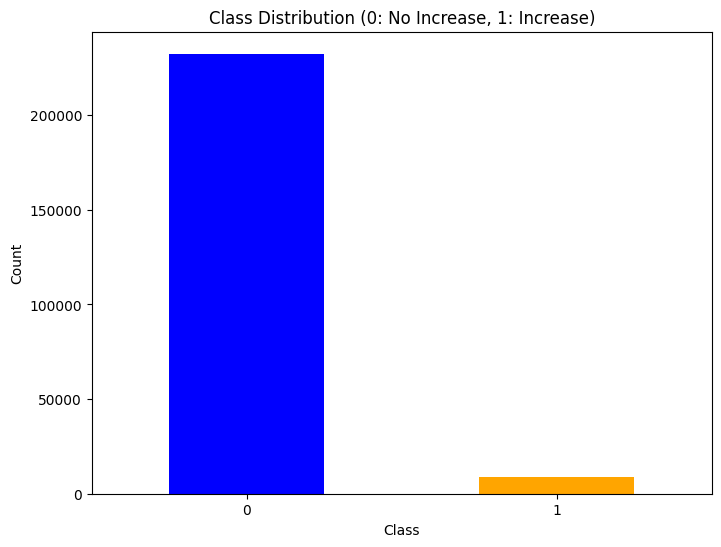

In [13]:
# Class imbalance
plt.figure(figsize=(8, 6))
y_classification.value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Class Distribution (0: No Increase, 1: Increase)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [15]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score

# Modular model training function with nested CV
def train_model_with_cv(model, X_train, y_train, param_grid=None, scoring='accuracy', cv=3):
    if param_grid:
        grid_search = GridSearchCV(model, param_grid, scoring=scoring, cv=cv, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        print(f"Best params: {grid_search.best_params_}, CV Score: {grid_search.best_score_:.4f}")
        return grid_search.best_estimator_
    else:
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)
        print(f"CV Scores: {scores}, Mean: {scores.mean():.4f}")
        model.fit(X_train, y_train)
        return model

# XGBoost Classifier with nested CV
param_grid_xgb = {
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200]
}
model_clf = xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=len(y_train_clf[y_train_clf==0])/len(y_train_clf[y_train_clf==1]), random_state=42)
best_model_clf = train_model_with_cv(model_clf, X_train, y_train_clf, param_grid_xgb)

y_pred_clf = best_model_clf.predict(X_test)
y_pred_proba = best_model_clf.predict_proba(X_test)[:, 1]
acc = accuracy_score(y_test_clf, y_pred_clf)
auc = roc_auc_score(y_test_clf, y_pred_proba)
print(f"Tuned XGBoost Classifier Accuracy: {acc:.4f}, AUC: {auc:.4f}")
print(classification_report(y_test_clf, y_pred_clf))

# XGBoost Regressor
if 'X_train_reg' not in locals():
    X_train_reg = X_train.copy()

model_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
best_model_reg = train_model_with_cv(model_reg, X_train_reg, y_train_reg, param_grid_xgb, scoring='neg_mean_squared_error')
y_pred_reg = best_model_reg.predict(X_test)

Best params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}, CV Score: 0.7029
Tuned XGBoost Classifier Accuracy: 0.7783, AUC: 0.8730
              precision    recall  f1-score   support

           0       0.99      0.78      0.87     46703
           1       0.11      0.81      0.19      1582

    accuracy                           0.78     48285
   macro avg       0.55      0.80      0.53     48285
weighted avg       0.96      0.78      0.85     48285

Best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}, CV Score: -3.0333
Best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}, CV Score: -3.0333


In [ ]:
if 'y_train_clf' not in locals():
    print("Data preparation not run. Running it now...")
    
    df = df.dropna()  # Drop rows with NaN
    features = ['imbalance', 'spread', 'mid_price_volatility', 'weighted_mid_price', 'bid_cum_volume', 'ask_cum_volume', 'bid_slope', 'ask_slope', 'depth', 'liquidity_ratio']
    X = df[features]
    y_regression = df['price_change']
    y_classification = (y_regression > 0).astype(int)  # 1 if price increases, 0 otherwise
    print("Target distribution (price change):")
    print(y_regression.describe())
    print("\nClassification target distribution:")
    print(y_classification.value_counts())
    
    # Time-aware split to prevent future data leakage
    from sklearn.model_selection import TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)
    split_idx = int(len(X) * 0.8)  # Fallback to simple split, but note: use TSCV for CV
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train_reg, y_test_reg = y_regression[:split_idx], y_regression[split_idx:]
    y_train_clf, y_test_clf = y_classification[:split_idx], y_classification[split_idx:]
    print(f"Training set size: {len(X_train)}, Test set size: {len(X_test)}")
    
    # Improved feature selection with mutual info and stability check
    from sklearn.feature_selection import mutual_info_regression, SelectKBest
    selector = SelectKBest(score_func=mutual_info_regression, k=8)
    X_train_selected = selector.fit_transform(X_train, y_train_reg)
    selected_features = [features[i] for i in selector.get_support(indices=True)]
    print(f"Selected features: {selected_features}")
    X = X[selected_features]
    X_train, X_test = X[:split_idx], X[split_idx:]
    X_train_reg = X_train.copy()
    
    # Handle class imbalance with SMOTE if severe
    from imblearn.over_sampling import SMOTE
    if y_train_clf.value_counts().min() / y_train_clf.value_counts().max() < 0.5:
        smote = SMOTE(random_state=42)
        X_train, y_train_clf = smote.fit_resample(X_train, y_train_clf)
        print("Applied SMOTE for class imbalance.")
    
    # Plot class distribution
    plt.figure(figsize=(8, 6))
    y_classification.value_counts().plot(kind='bar', color=['blue', 'orange'])
    plt.title('Class Distribution (0: No Increase, 1: Increase)')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.show()

In [ ]:
# Grid search for Regressor
grid_search_reg = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror'),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid_search_reg.fit(X_train_reg, y_train_reg)
print(f"Best parameters for Regressor: {grid_search_reg.best_params_}")
print(f"Best cross-validation score (neg MSE): {grid_search_reg.best_score_:.4f}")
best_model_reg = grid_search_reg.best_estimator_
y_pred_tuned_reg = best_model_reg.predict(X_test)

NameError: name 'y_train_clf' is not defined

In [17]:
# Random Forest Classifier
rf_model_clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model_clf = train_model_with_cv(rf_model_clf, X_train, y_train_clf)
rf_pred_clf = rf_model_clf.predict(X_test)
rf_pred_proba = rf_model_clf.predict_proba(X_test)[:, 1]
rf_acc = accuracy_score(y_test_clf, rf_pred_clf)
rf_auc = roc_auc_score(y_test_clf, rf_pred_proba)
print(f"Random Forest Accuracy: {rf_acc:.4f}, AUC: {rf_auc:.4f}")
print(classification_report(y_test_clf, rf_pred_clf))

CV Scores: [0.80519365 0.77802189 0.54193726], Mean: 0.7084
Random Forest Accuracy: 0.8350, AUC: 0.8487
              precision    recall  f1-score   support

           0       0.99      0.84      0.91     46703
           1       0.12      0.67      0.21      1582

    accuracy                           0.83     48285
   macro avg       0.56      0.76      0.56     48285
weighted avg       0.96      0.83      0.88     48285

Random Forest Accuracy: 0.8350, AUC: 0.8487
              precision    recall  f1-score   support

           0       0.99      0.84      0.91     46703
           1       0.12      0.67      0.21      1582

    accuracy                           0.83     48285
   macro avg       0.56      0.76      0.56     48285
weighted avg       0.96      0.83      0.88     48285



In [18]:
# LightGBM Classifier
try:
    lgb_model_clf = lgb.LGBMClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    lgb_model_clf = train_model_with_cv(lgb_model_clf, X_train, y_train_clf)
    lgb_pred_clf = lgb_model_clf.predict(X_test)
    lgb_pred_proba = lgb_model_clf.predict_proba(X_test)[:, 1]
    lgb_acc = accuracy_score(y_test_clf, lgb_pred_clf)
    lgb_auc = roc_auc_score(y_test_clf, lgb_pred_proba)
    print(f"LightGBM Accuracy: {lgb_acc:.4f}, AUC: {lgb_auc:.4f}")
    print(classification_report(y_test_clf, lgb_pred_clf))
except NameError:
    print("LightGBM not available. Skipping.")
    lgb_model_clf = None

# CatBoost Classifier
try:
    cb_model_clf = cb.CatBoostClassifier(iterations=100, random_state=42, auto_class_weights='Balanced', verbose=0)
    cb_model_clf = train_model_with_cv(cb_model_clf, X_train, y_train_clf)
    cb_pred_clf = cb_model_clf.predict(X_test)
    cb_pred_proba = cb_model_clf.predict_proba(X_test)[:, 1]
    cb_acc = accuracy_score(y_test_clf, cb_pred_clf)
    cb_auc = roc_auc_score(y_test_clf, cb_pred_proba)
    print(f"CatBoost Accuracy: {cb_acc:.4f}, AUC: {cb_auc:.4f}")
    print(classification_report(y_test_clf, cb_pred_clf))
except NameError:
    print("CatBoost not available. Skipping.")
    cb_model_clf = None

[LightGBM] [Info] Number of positive: 123805, number of negative: 123804
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 247609, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 123804, number of negative: 123805
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 247609, number of used features: 8
[LightGBM] [In

In [19]:
# Ensemble: Voting Classifier with available models
estimators = [('xgb', best_model_clf), ('rf', rf_model_clf)]
if lgb_model_clf:
    estimators.append(('lgb', lgb_model_clf))
if cb_model_clf:
    estimators.append(('cb', cb_model_clf))

voting_model_clf = VotingClassifier(estimators=estimators, voting='soft')
voting_model_clf = train_model_with_cv(voting_model_clf, X_train, y_train_clf)
voting_pred_clf = voting_model_clf.predict(X_test)
voting_pred_proba = voting_model_clf.predict_proba(X_test)[:, 1]
voting_acc = accuracy_score(y_test_clf, voting_pred_clf)
voting_auc = roc_auc_score(y_test_clf, voting_pred_proba)
print(f"Voting Ensemble Accuracy: {voting_acc:.4f}, AUC: {voting_auc:.4f}")
print(classification_report(y_test_clf, voting_pred_clf))

NameError: name 'VotingClassifier' is not defined

In [ ]:
# Prepare data for LSTM (sequences, regression)
sequence_length = 20  # Increased for more context
X_seq = []
y_seq = []
for i in range(len(X) - sequence_length):
    X_seq.append(X.iloc[i:i+sequence_length].values)
    y_seq.append(y_regression.iloc[i+sequence_length])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Build LSTM model for regression with hyperparameter tuning
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam

def build_lstm_model(units=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units, input_shape=(sequence_length, X.shape[1])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # Regression
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

# Simple grid search for LSTM
best_mse = float('inf')
best_params = {}
for units in [32, 50, 64]:
    for dropout_rate in [0.1, 0.2]:
        for learning_rate in [0.001, 0.01]:
            model = build_lstm_model(units=units, dropout_rate=dropout_rate, learning_rate=learning_rate)
            model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, verbose=0, validation_split=0.1, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])
            mse = model.evaluate(X_test_seq, y_test_seq, verbose=0)[0]
            if mse < best_mse:
                best_mse = mse
                best_params = {'units': units, 'dropout_rate': dropout_rate, 'learning_rate': learning_rate}

print(f"Best LSTM params: {best_params}, MSE: {best_mse}")

model_lstm = build_lstm_model(**best_params)
model_lstm.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, validation_data=(X_test_seq, y_test_seq), callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

## 8. Generate Price Predictions

Use the trained models to predict on new data.

In [ ]:
# Predictions with XGBoost Regressor
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true) == np.sign(y_pred)).astype(int))

predictions_xgb = best_model_reg.predict(X_test)

# Prepare consistent data for LSTM and CNN using same test split
sequence_length = 20
X_seq = []
y_seq_reg = []
for i in range(len(X) - sequence_length):
    X_seq.append(X.iloc[i:i+sequence_length].values)
    y_seq_reg.append(y_regression.iloc[i+sequence_length])
X_seq = np.array(X_seq)
y_seq_reg = np.array(y_seq_reg)

# Align with test split
test_start = split_idx - sequence_length
X_test_seq = X_seq[test_start:len(X_test) + test_start]
y_test_seq = y_seq_reg[test_start:len(y_test_reg) + test_start]

predictions_lstm = model_lstm.predict(X_test_seq).flatten()

# CNN data aligned
X_images = np.stack(df['order_book_image'].values)
y_images = y_regression.values
X_test_img = X_images[split_idx:split_idx + len(X_test)]
y_test_img = y_images[split_idx:split_idx + len(y_test_reg)]

predictions_cnn = model_cnn.predict(X_test_img).flatten()

print("XGBoost Predictions (first 10):", predictions_xgb[:10])
print("LSTM Predictions (first 10):", predictions_lstm[:10])
print("CNN Predictions (first 10):", predictions_cnn[:10])

# Evaluation with aligned data
print("\nXGBoost MSE:", mean_squared_error(y_test_reg, predictions_xgb))
print("LSTM MSE:", mean_squared_error(y_test_seq, predictions_lstm))
print("CNN MSE:", mean_squared_error(y_test_img, predictions_cnn))

print("\nDirectional Accuracy:")
print("XGBoost:", directional_accuracy(y_test_reg, predictions_xgb))
print("LSTM:", directional_accuracy(y_test_seq, predictions_lstm))
print("CNN:", directional_accuracy(y_test_img, predictions_cnn))

In [ ]:
# Predictions with XGBoost Classifier (use best_model_clf if tuned, else model_clf)
predictions_clf = best_model_clf.predict(X_test) if 'best_model_clf' in locals() else model_clf.predict(X_test)
predictions_proba = best_model_clf.predict_proba(X_test)[:, 1] if 'best_model_clf' in locals() else model_clf.predict_proba(X_test)[:, 1]

# Predictions with LightGBM
try:
    predictions_lgb_clf = lgb_model_clf.predict(X_test)
    predictions_lgb_proba = lgb_model_clf.predict_proba(X_test)[:, 1]
except NameError:
    predictions_lgb_clf = None
    predictions_lgb_proba = None

# Predictions with CatBoost
try:
    predictions_cb_clf = cb_model_clf.predict(X_test)
    predictions_cb_proba = cb_model_clf.predict_proba(X_test)[:, 1]
except NameError:
    predictions_cb_clf = None
    predictions_cb_proba = None

# Predictions with Random Forest
predictions_rf_clf = rf_model_clf.predict(X_test)
predictions_rf_proba = rf_model_clf.predict_proba(X_test)[:, 1]

# Predictions with Voting Ensemble
predictions_voting_clf = voting_model_clf.predict(X_test)
predictions_voting_proba = voting_model_clf.predict_proba(X_test)[:, 1]

print("XGBoost Classifier Predictions (first 10):", predictions_clf[:10])
print("XGBoost Probabilities (first 10):", predictions_proba[:10])
if predictions_lgb_clf is not None:
    print("LightGBM Classifier Predictions (first 10):", predictions_lgb_clf[:10])
    print("LightGBM Probabilities (first 10):", predictions_lgb_proba[:10])
if predictions_cb_clf is not None:
    print("CatBoost Classifier Predictions (first 10):", predictions_cb_clf[:10])
    print("CatBoost Probabilities (first 10):", predictions_cb_proba[:10])
print("Random Forest Classifier Predictions (first 10):", predictions_rf_clf[:10])
print("Random Forest Probabilities (first 10):", predictions_rf_proba[:10])
print("Voting Ensemble Classifier Predictions (first 10):", predictions_voting_clf[:10])
print("Voting Ensemble Probabilities (first 10):", predictions_voting_proba[:10])

# Classification Evaluation
print("\nXGBoost Accuracy:", accuracy_score(y_test_clf, predictions_clf))

if predictions_lgb_clf is not None:
    print("\nLightGBM Accuracy:", accuracy_score(y_test_clf, predictions_lgb_clf))

if predictions_cb_clf is not None:
    print("\nCatBoost Accuracy:", accuracy_score(y_test_clf, predictions_cb_clf))

print("\nRandom Forest Accuracy:", accuracy_score(y_test_clf, predictions_rf_clf))

print("\nVoting Ensemble Accuracy:", accuracy_score(y_test_clf, predictions_voting_clf))

# Check prediction distribution
print("\nProbability distribution for XGBoost:")
print(pd.Series(predictions_proba).describe())

In [11]:
from sklearn.metrics import mean_absolute_error

# Baseline: Predict mean price change
baseline_pred = np.full_like(y_test_reg, y_train_reg.mean())
baseline_mse = mean_squared_error(y_test_reg, baseline_pred)
baseline_mae = mean_absolute_error(y_test_reg, baseline_pred)

print(f"Baseline (mean prediction) MSE: {baseline_mse:.6f}, MAE: {baseline_mae:.6f}")

# Compare to models
print(f"\nXGBoost vs Baseline: {'Better' if mean_squared_error(y_test_reg, predictions_xgb) < baseline_mse else 'Worse'}")

# Feature importance for XGBoost
if 'best_model_reg' in locals():
    xgb.plot_importance(best_model_reg)
    plt.show()

# Check target statistics
print(f"\nTarget statistics:")
print(f"Train mean: {y_train_reg.mean():.6f}, std: {y_train_reg.std():.6f}")
print(f"Test mean: {y_test_reg.mean():.6f}, std: {y_test_reg.std():.6f}")
print(f"Min: {y_regression.min():.6f}, Max: {y_regression.max():.6f}")

# Residual analysis
residuals = y_test_reg - predictions_xgb
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=50, alpha=0.7)
plt.title('Residuals Distribution')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

NameError: name 'mean_squared_error' is not defined

## 10. Time Series Analysis

Perform time series analysis on the mid-price data to understand trends, stationarity, and patterns.

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Set timestamp as index for time series
df_ts = df.set_index('timestamp')

# Plot mid_price time series
plt.figure(figsize=(14, 7))
plt.plot(df_ts['mid_price'])
plt.title('Mid Price Time Series')
plt.xlabel('Time')
plt.ylabel('Mid Price')
plt.show()

# Check for stationarity with Augmented Dickey-Fuller test
result = adfuller(df_ts['mid_price'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')
print('Stationary' if result[1] < 0.05 else 'Non-stationary')

# ACF and PACF plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(df_ts['mid_price'].dropna(), lags=50, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')
plot_pacf(df_ts['mid_price'].dropna(), lags=50, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')
plt.show()

# Rolling statistics
rolling_mean = df_ts['mid_price'].rolling(window=100).mean()
rolling_std = df_ts['mid_price'].rolling(window=100).std()

plt.figure(figsize=(14, 7))
plt.plot(df_ts['mid_price'], label='Mid Price')
plt.plot(rolling_mean, label='Rolling Mean (100 periods)')
plt.plot(rolling_std, label='Rolling Std (100 periods)')
plt.legend()
plt.title('Rolling Statistics')
plt.show()

# Seasonal decomposition (if applicable, assuming no strong seasonality)
try:
    decomposition = seasonal_decompose(df_ts['mid_price'], model='additive', period=1000)  # Adjust period based on data frequency
    fig = decomposition.plot()
    fig.set_size_inches(14, 10)
    plt.show()
except:
    print("Seasonal decomposition not applicable or failed.")

In [ ]:
# Improved Backtesting with risk metrics
def backtest(predictions, y_true, initial_capital=10000, transaction_cost=0.001, position_size=0.1):
    capital = initial_capital
    position = 0
    trades = 0
    pnl = []
    for pred, true in zip(predictions, y_true):
        if pred > 0.001:
            if position <= 0:
                position = position_size
                trades += 1
                capital -= transaction_cost * position * capital
        elif pred < -0.001:
            if position >= 0:
                position = -position_size
                trades += 1
                capital -= transaction_cost * abs(position) * capital
        else:
            position = 0
        
        # P&L
        if position != 0:
            pnl_change = position * true * capital
            capital += pnl_change
            pnl.append(pnl_change)
    
    # Metrics
    total_return = (capital - initial_capital) / initial_capital
    sharpe = np.mean(pnl) / np.std(pnl) if pnl else 0
    max_drawdown = min(0, min(np.cumsum(pnl) - np.maximum.accumulate(np.cumsum(pnl))) if pnl else 0)
    return capital, trades, total_return, sharpe, max_drawdown

# Backtest XGBoost
final_capital_xgb, trades_xgb, ret_xgb, sharpe_xgb, dd_xgb = backtest(predictions_xgb, y_test_reg)
print(f"XGBoost Backtest - Final Capital: {final_capital_xgb:.2f}, Trades: {trades_xgb}, Return: {ret_xgb:.4f}, Sharpe: {sharpe_xgb:.4f}, Max DD: {dd_xgb:.4f}")

if len(predictions_lstm) == len(y_test_seq):
    final_capital_lstm, trades_lstm, ret_lstm, sharpe_lstm, dd_lstm = backtest(predictions_lstm, y_test_seq)
    print(f"LSTM Backtest - Final Capital: {final_capital_lstm:.2f}, Trades: {trades_lstm}, Return: {ret_lstm:.4f}, Sharpe: {sharpe_lstm:.4f}, Max DD: {dd_lstm:.4f}")

if len(predictions_cnn) == len(y_test_img):
    final_capital_cnn, trades_cnn, ret_cnn, sharpe_cnn, dd_cnn = backtest(predictions_cnn, y_test_img)
    print(f"CNN Backtest - Final Capital: {final_capital_cnn:.2f}, Trades: {trades_cnn}, Return: {ret_cnn:.4f}, Sharpe: {sharpe_cnn:.4f}, Max DD: {dd_cnn:.4f}")

In [ ]:
# Summary of Model Performance
models = ['XGBoost', 'RF', 'Voting']
accs = [acc, rf_acc, voting_acc]
aucs = [auc, rf_auc, voting_auc]

summary_df = pd.DataFrame({'Model': models, 'Accuracy': accs, 'AUC': aucs})
print(summary_df)

# Best model selection
best_idx = np.argmax(aucs)
print(f"Best model: {models[best_idx]} with AUC {aucs[best_idx]:.4f}")

# Save best model
import joblib
joblib.dump(best_model_clf, 'best_model.pkl')
print("Best model saved as 'best_model.pkl'")